In [7]:
import mne
from MaxDaVit import MaxDaViT
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torchmetrics
import sklearn.metrics

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Load the data from edf file
raw = mne.io.read_raw_edf('E:\\Documents\\datasets\\EEG Motor IMG\\files\\\S010\\S010R02.edf', preload=True)

# Load the model
maxDaVit = MaxDaViT(num_classes=5,dim=32,depth=(1,1,2,1),dim_conv_stem=3,window_size=(10,4))
maxDaVit.load_state_dict(torch.load("E:/Documents/JupNotebooks/AIModels/EEG/Trained models/MaxVit11.pt"))
maxDaVit.eval()
maxDaVit.to(device)

mean, std = torch.load("E:/Documents/datasets/MotorImgTorch_mean_std.pt")

print(raw.annotations.description)

seq_onsets = np.arange(raw.get_data()[0].shape[0])/160

runs_classes_1 = [5, 6, 9, 10, 13, 14]#different runs correspond to different classes
def get_classes_for_seqs(data_edf,run):
  #get class of run: if the run is not class one, the result is zero
  run_class = np.sum(np.equal(runs_classes_1,run))
  x_one_seq = data_edf.get_data()
  x_seqs = []
  y_seqs = []
  last_index = x_one_seq[0].shape[0]
  ann_len = data_edf.annotations.onset.shape[0]
  for i in range(ann_len-1,-1,-1):#go through ann and save y_data as seperate seqs
    try:
      cur_index = np.where(np.equal(data_edf.annotations.onset[i],seq_onsets))[0][0]#get index where x==ann(start of new_seq)
    except:
      continue

    # pad data with zeros if the seq is too short, if to long, cut it off
    x_seqs_cur = x_one_seq[:,cur_index:last_index]
    print(x_seqs_cur.shape)
    if(last_index-cur_index<736):
      if(run<3):
        continue
      x_seqs_cur = np.pad(x_seqs_cur, pad_width=((0,0),(0,736-(last_index-cur_index))), mode='constant', constant_values=0)
    elif(last_index-cur_index>736 and run>2):
      x_seqs_cur = x_seqs_cur[:,:736]

    x_seqs.append(x_seqs_cur)
    annotation_int = int(data_edf.annotations.description[i][1])
    if annotation_int==0:
      y_seqs.append(0)
    elif annotation_int==1:
      y_seqs.append(1+run_class)
    elif annotation_int==2:
      y_seqs.append(3+run_class)
    last_index = cur_index

  x_seqs.reverse()
  y_seqs.reverse()

  x_seqs = torch.tensor(x_seqs,dtype=torch.float32)
  y_seqs = torch.tensor(y_seqs,dtype=torch.int64)
  
  # if run==1 or 2: divide the data in non-overlapping windows with 610 samples: 3.8s
  if(run==1 or run==2):
    x_seqs = x_seqs.unfold(2, 610, 610).squeeze(0).transpose(0,1)
    y_seqs = y_seqs.expand(610)

  # window the data with 75% overlapping windows
  x_seqs = x_seqs.unfold(2, 160, 40).transpose(1,2).transpose(2,3)

  return x_seqs,y_seqs

test_x, test_y = get_classes_for_seqs(raw,2)
test_x.shape

Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S010\S010R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
['T0']
(64, 9760)


C:\Users\jonat\AppData\Local\Temp\ipykernel_21484\652967670.py:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)
  x_seqs = torch.tensor(x_seqs,dtype=torch.float32)


torch.Size([16, 12, 160, 64])

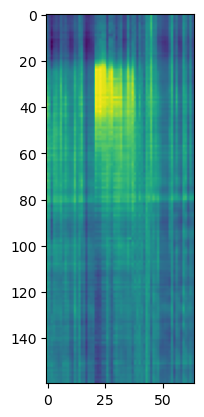

In [3]:
plt.imshow(test_x[0][0])

In [4]:
def maxDaViTInference(x):
    with torch.no_grad():
        x = (x-mean)/std
        x = x.unsqueeze(1).to(device)
        y_pred = maxDaVit(x)
        
    return (torch.sum(y_pred,0)/x.shape[0]).unsqueeze(0)



print(test_y[2])
maxDaViTInference(test_x[2])

tensor(0)


tensor([[ 0.7978,  6.7069, -2.8108, -0.0321, -4.2772]], device='cuda:0')

In [47]:
data_path = "E:\\Documents\\datasets\\EEG Motor IMG\\files\\"
def get_edf_file_paths():
  edf_file_paths = []
  for path in os.listdir(data_path):
    cur_path = os.path.join(data_path,path)
    if os.path.isdir(cur_path):#get every SXXX directory
      for file in os.listdir(cur_path):
        if os.path.splitext(file)[1]==".edf":#dont get the .edf.event files
          edf_file_paths.append(os.path.join(cur_path,file))
                  
  return edf_file_paths
                    
file_paths = get_edf_file_paths()
print(len(file_paths))

1526


In [48]:
for path in file_paths:
    print(path)

E:\Documents\datasets\EEG Motor IMG\files\S001\S001R01.edf
E:\Documents\datasets\EEG Motor IMG\files\S001\S001R02.edf
E:\Documents\datasets\EEG Motor IMG\files\S001\S001R03.edf
E:\Documents\datasets\EEG Motor IMG\files\S001\S001R04.edf
E:\Documents\datasets\EEG Motor IMG\files\S001\S001R05.edf
E:\Documents\datasets\EEG Motor IMG\files\S001\S001R06.edf
E:\Documents\datasets\EEG Motor IMG\files\S001\S001R07.edf
E:\Documents\datasets\EEG Motor IMG\files\S001\S001R08.edf
E:\Documents\datasets\EEG Motor IMG\files\S001\S001R09.edf
E:\Documents\datasets\EEG Motor IMG\files\S001\S001R10.edf
E:\Documents\datasets\EEG Motor IMG\files\S001\S001R11.edf
E:\Documents\datasets\EEG Motor IMG\files\S001\S001R12.edf
E:\Documents\datasets\EEG Motor IMG\files\S001\S001R13.edf
E:\Documents\datasets\EEG Motor IMG\files\S001\S001R14.edf
E:\Documents\datasets\EEG Motor IMG\files\S002\S002R01.edf
E:\Documents\datasets\EEG Motor IMG\files\S002\S002R02.edf
E:\Documents\datasets\EEG Motor IMG\files\S002\S002R03.e

In [62]:
# run all the metrics on the inference method:

loss_fn = torch.nn.CrossEntropyLoss()
running_tloss = 0.0
tcorrect = 0.0
# reproducibility
seed = 21
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.ic = True
torch.backends.cudnn.benchmark = False

target = []
preds  = []
pred_rates = []

num_preds = 0
i = 0
for file_path in file_paths:
    raw = mne.io.read_raw_edf(file_path, preload=True)
    x_seqs, y_seqs = get_classes_for_seqs(raw,i%14+1)
    for x,y in zip(x_seqs,y_seqs):
        y_pred = maxDaViTInference(x)
        y = y.unsqueeze(0).to(device)
        pred_rates.append(y_pred)
        tloss = loss_fn(y_pred, y)
        y_pred = torch.argmax(y_pred, dim=1)
        target.append(y)
        preds.append(y_pred)
        num_preds += 1
        tcorrect += (y_pred == y).type(torch.float).sum().item()
        running_tloss += tloss
        
    if i%3==0:
        print(f"{num_preds} loss: {running_tloss/num_preds}, acc: {tcorrect/num_preds}")

    i += 1
    
    # if i%3==0:
    #     print(f"{i}/1089590 loss: {running_tloss/num_preds}, acc: {tcorrect/num_preds}")

target = torch.cat(target)
pred_rates = torch.cat(pred_rates)
preds = torch.cat(preds)

Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S001\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
16 loss: 0.2629573345184326, acc: 0.8125
Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S001\S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S001\S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
80 loss: 0.19262650609016418, acc

C:\Users\jonat\AppData\Local\Temp\ipykernel_23200\3441896250.py:21: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S100\S100R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...


C:\Users\jonat\AppData\Local\Temp\ipykernel_23200\3441896250.py:21: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)


31584 loss: 0.09533415734767914, acc: 0.9693832320162108
Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S100\S100R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...


C:\Users\jonat\AppData\Local\Temp\ipykernel_23200\3441896250.py:21: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S100\S100R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...


C:\Users\jonat\AppData\Local\Temp\ipykernel_23200\3441896250.py:21: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S100\S100R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...


C:\Users\jonat\AppData\Local\Temp\ipykernel_23200\3441896250.py:21: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)


31617 loss: 0.09666632860898972, acc: 0.9687826169465794
Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S100\S100R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...


C:\Users\jonat\AppData\Local\Temp\ipykernel_23200\3441896250.py:21: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S100\S100R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...


C:\Users\jonat\AppData\Local\Temp\ipykernel_23200\3441896250.py:21: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S100\S100R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...


C:\Users\jonat\AppData\Local\Temp\ipykernel_23200\3441896250.py:21: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)


31650 loss: 0.09778956323862076, acc: 0.9685624012638231
Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S100\S100R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...


C:\Users\jonat\AppData\Local\Temp\ipykernel_23200\3441896250.py:21: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S100\S100R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...


C:\Users\jonat\AppData\Local\Temp\ipykernel_23200\3441896250.py:21: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S100\S100R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...


C:\Users\jonat\AppData\Local\Temp\ipykernel_23200\3441896250.py:21: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)


31683 loss: 0.09936089813709259, acc: 0.9681532683142379
Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S100\S100R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...


C:\Users\jonat\AppData\Local\Temp\ipykernel_23200\3441896250.py:21: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S101\S101R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S101\S101R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
31726 loss: 0.10019474476575851, acc: 0.9677866733909096
Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S101\S101R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from E:\Documents\datasets\EEG Motor IMG\files\S101\S101R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF pa

In [63]:
#torch.save((target.to('cpu'),preds.to('cpu'),pred_rates.to('cpu')), "Tests/NoWindowPred.pt")

In [5]:
target, preds, pred_rates = torch.load("Tests/NoWindowPred.pt")

tensor([[18211,   360,   214,   321,   106],
        [   22,  3829,     4,     4,     2],
        [   10,     0,  3815,     1,     0],
        [   10,     1,     2,  3818,     0],
        [   11,     0,     3,     2,  3812]])
[[9.4789714e-01 1.8738288e-02 1.1138871e-02 1.6708307e-02 5.5173850e-03]
 [5.6980057e-03 9.9171197e-01 1.0360010e-03 1.0360010e-03 5.1800051e-04]
 [2.6136958e-03 0.0000000e+00 9.9712491e-01 2.6136957e-04 0.0000000e+00]
 [2.6102844e-03 2.6102844e-04 5.2205689e-04 9.9660659e-01 0.0000000e+00]
 [2.8735632e-03 0.0000000e+00 7.8369904e-04 5.2246603e-04 9.9582022e-01]]


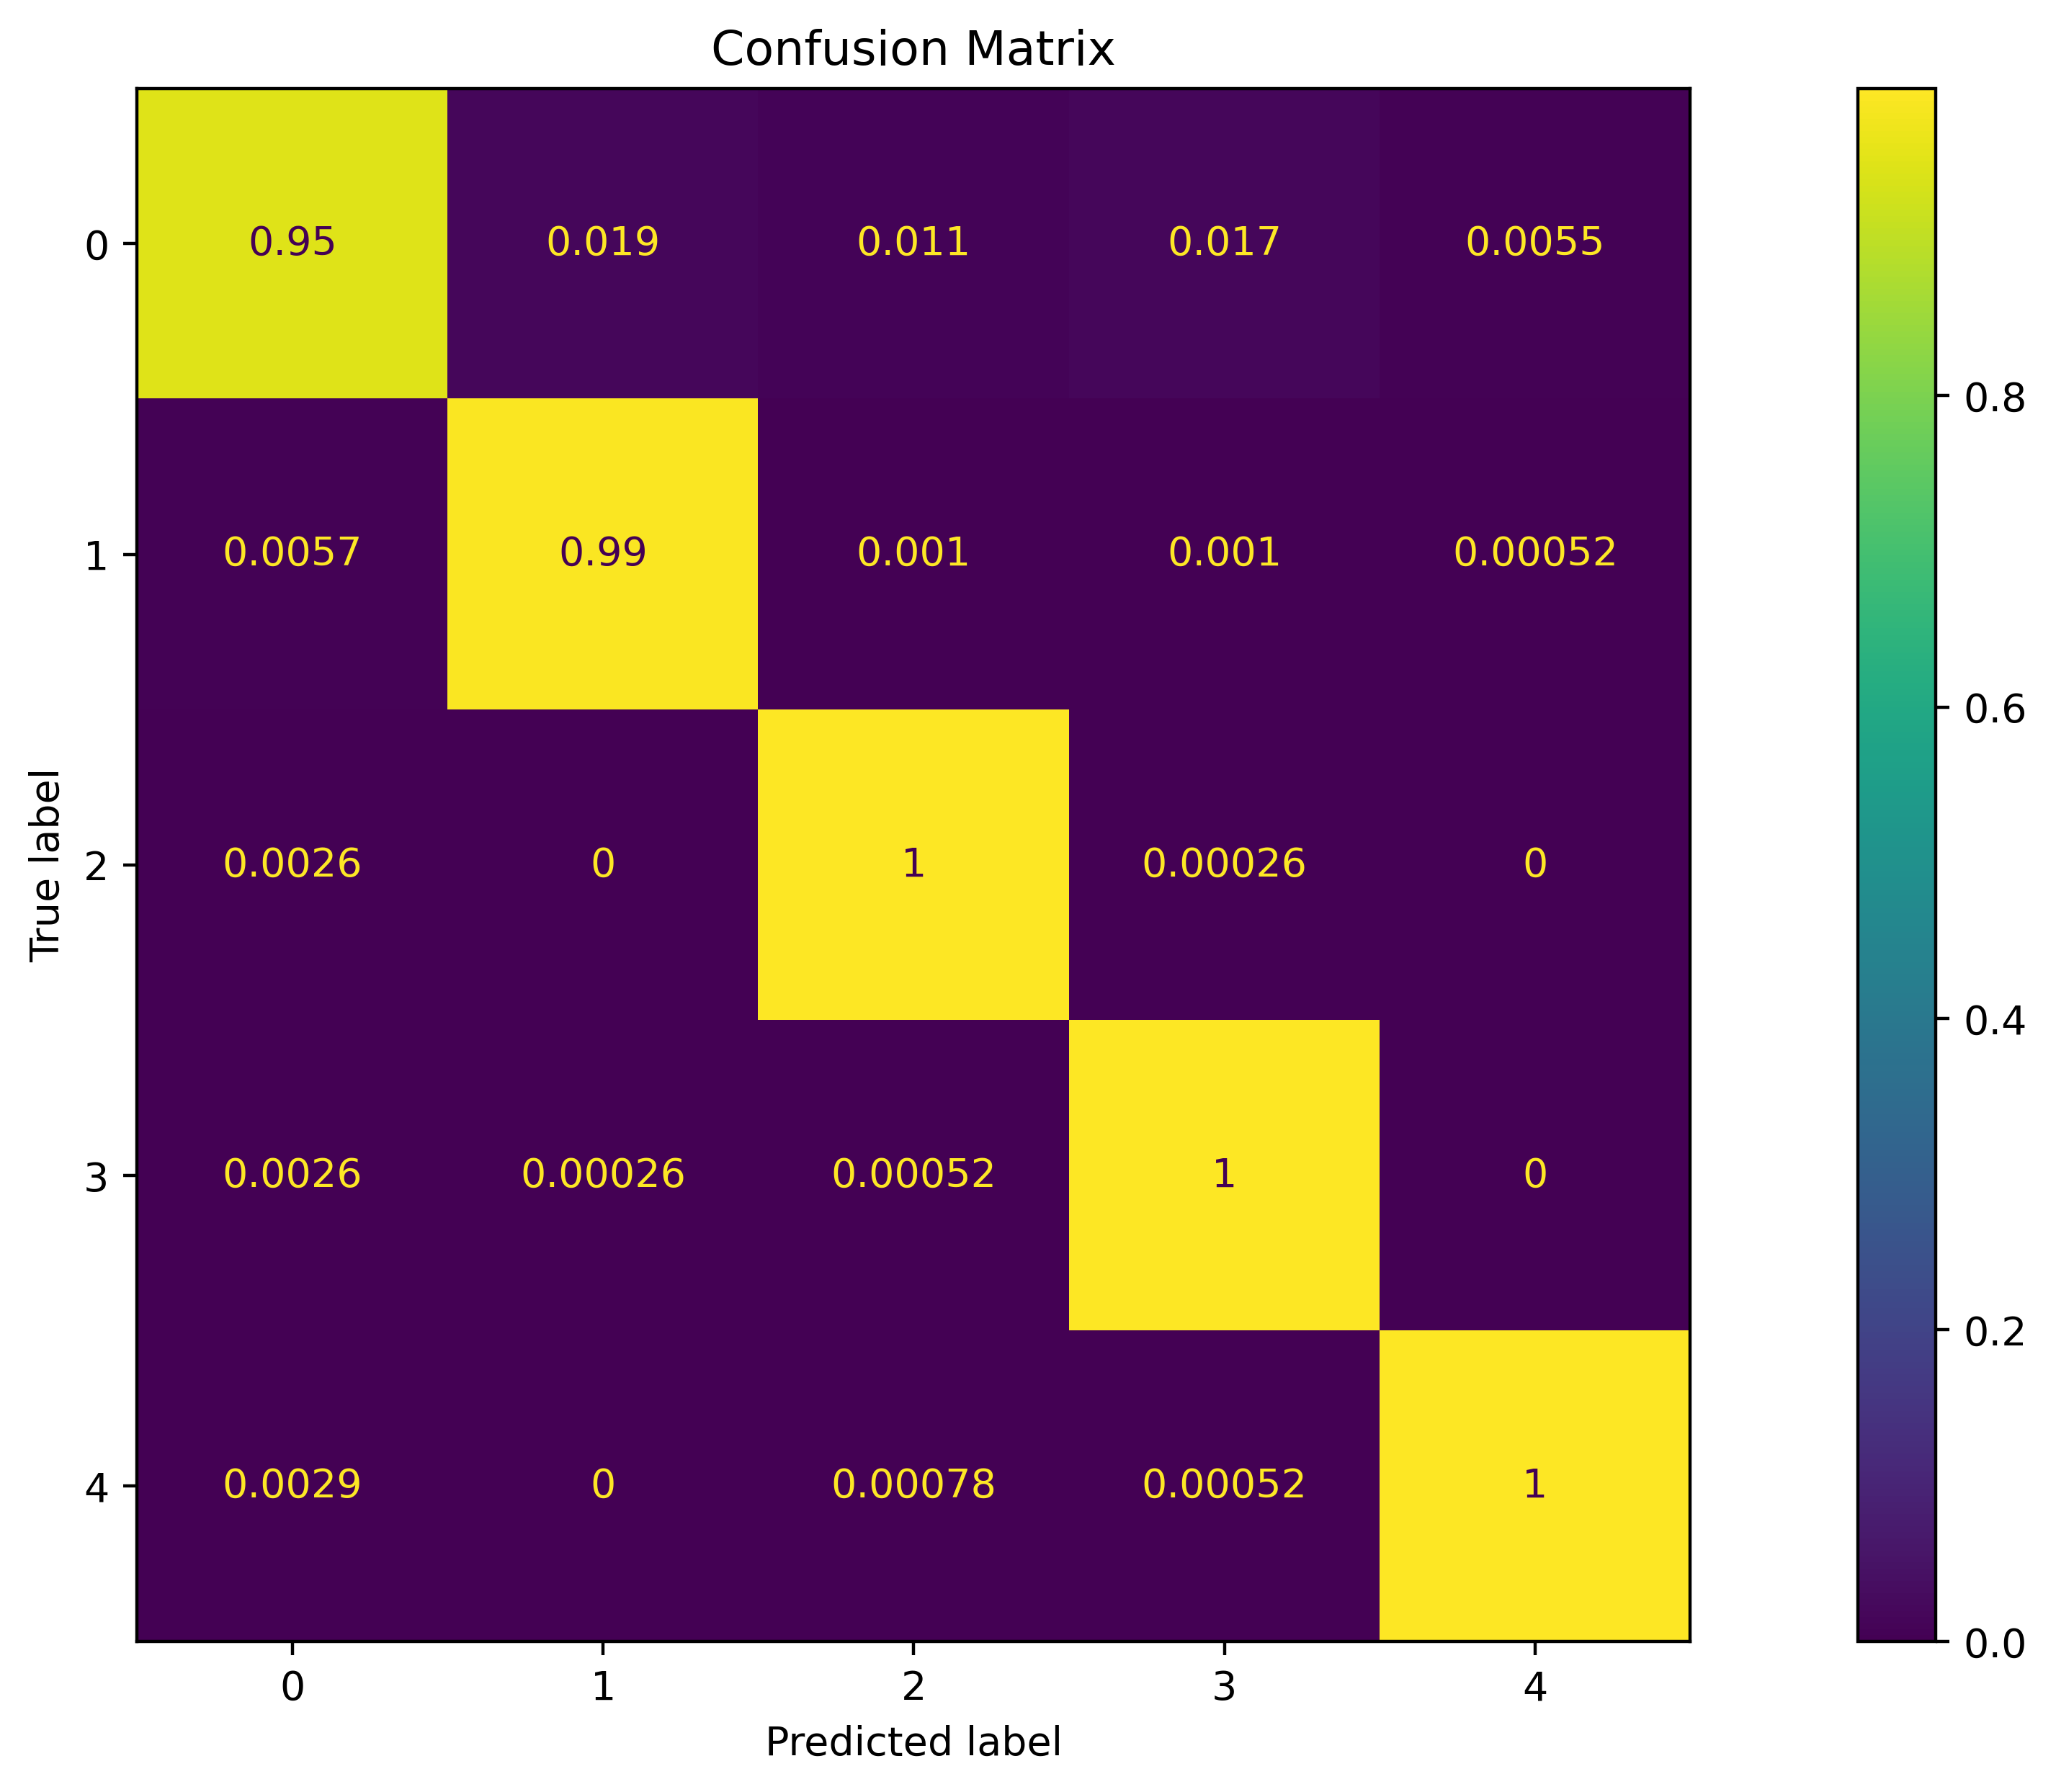

In [15]:
fig = plt.figure(figsize=(15,7),dpi=400)
ax1 = fig.add_subplot(111)

confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=5)
confmat = confmat(preds, target)
confmat_r = confmat.to(torch.float32)
print(confmat)
# calculate relative in each class
for(i,j), val in np.ndenumerate(confmat):
    confmat_r[i,j] = val/confmat[i,:].sum()

print(confmat_r.numpy())

cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confmat_r.numpy(), display_labels = ["0","1","2","3","4"])

ax1.set_title("Confusion Matrix")
cm_display.plot(ax=ax1)

# ax1.set_title("Confusion Matrix")
# ax1.imshow(confmat_r)
# confmat_r

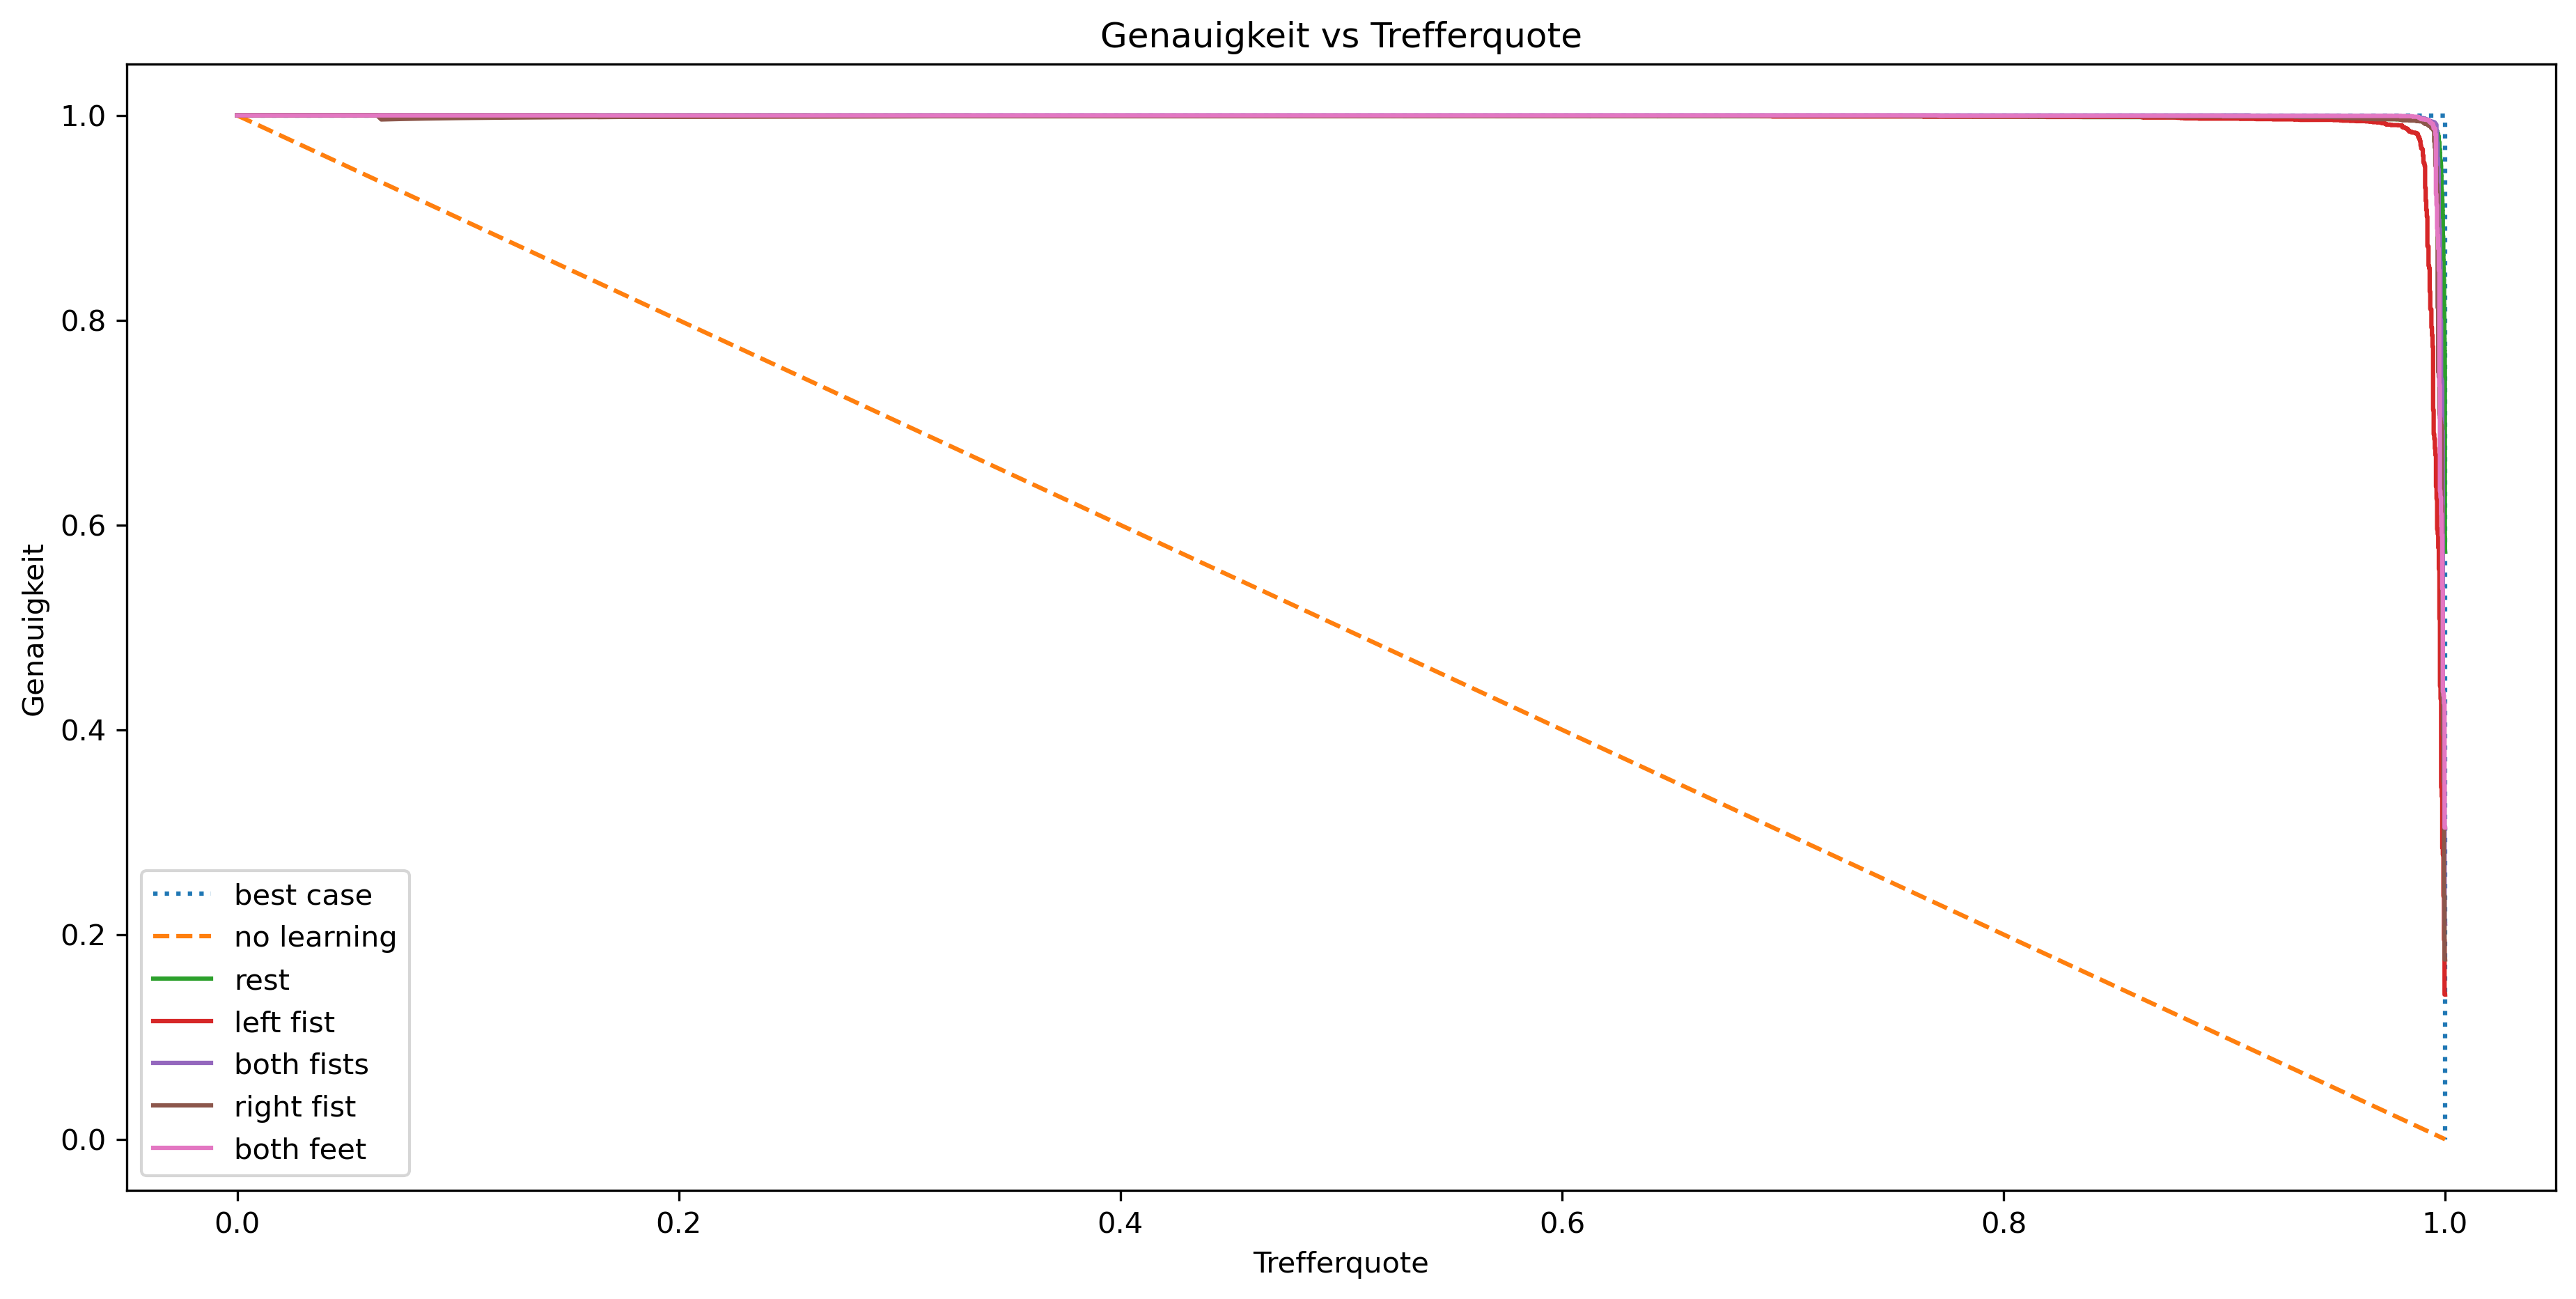

In [6]:
fig = plt.figure(figsize=(15,7),dpi=300)
ax1 = fig.add_subplot(111)

pr_curve = torchmetrics.PrecisionRecallCurve(task="multiclass", num_classes=5)
precision, recall, thresholds = pr_curve(pred_rates, target)

ax1.plot([0,1,1],[1,1,0], ":")
ax1.plot([1,0], "--")
ax1.plot(recall[0], precision[0])
ax1.plot(recall[1], precision[1])
ax1.plot(recall[2], precision[2])
ax1.plot(recall[3], precision[3])
ax1.plot(recall[4], precision[4])

labels = ["best case", "no learning", "rest", "left fist", "both fists", "right fist", "both feet"]

ax1.set_xlabel("Trefferquote")
ax1.set_ylabel("Genauigkeit")
ax1.set_title("Genauigkeit vs Trefferquote")
ax1.legend(labels, loc="lower left")